# Homework 4: Oliver Muellerklein

Collaboration with Jacob Bukoski and Zhongqi Miao.

In [1]:
import sys

#sys.path.append('/usr/local/lib/python3.5/site-packages')
#sys.path

### Amdahl's Law:

*Note:* the following is a summary from the Parallel Programming PDF (reference).

There are several general principles of parallel programming to consider:

* Finding Enough Parallelism (see Amdahl's Law)
* Granularity - bite-sized chunks, but only for large amount of work because of overhead
* Locality - size of memory slows down the operation
* Load Balance
* Coordination and Synchronization - communication between nodes is expensive but it is better than getting the wrong answer

The following code demonstrates Amdahl's Law of predicting the theoretical improvement (speed increase) of a task based on improved resources. The theoretical improvement can be formulated as: 

S_latency at s = 1 / (1 - p) + p / s 

where, 

* p = percentage of execution time of whole task
* s = time improvement (i.e. speedup)
* S_latency = theoretical improvement in latency of execution of whole task

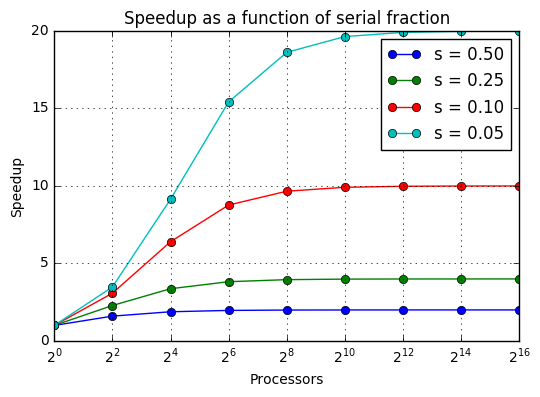

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def amdahl(s, p):
    return 1.0 / (s + (1.0 - s) / p)

p = np.logspace(0, 16, 9, base = 2)
ax = plt.subplot(111)

for s in [0.5, 0.25, 0.1, 0.05]:
    sp = amdahl(s, p)
    ax.semilogx(p, sp, '-o', label = 's = %.2f' % s, basex = 2.0)

ax.set_xlabel('Processors')
ax.set_ylabel('Speedup')
ax.set_title('Speedup as a function of serial fraction')
ax.legend()
ax.grid()
plt.show()

In the figure above, the key showing the various values of *s* can be understood as the inverse percentage of potential parallel portion. In other words, *s = 0.05* is equivalent to stating that *95%* of the task could be made to execute in parallel. Thus, we see the biggest improvement in speedup.  

In [4]:
from time import time
from multiprocessing import Pool
import ipyparallel as ipyp

## Create global ipyparallel listener 
ipypListen = ipyp.Client()

In [5]:
NUM_CORES = 8

def Throwing(dartss, coress):
    
    ## Because in parallel each function call is scoped independently
    ## ... thus, need to place some dependencies in functions
    from random import uniform as rUniform 
    from math import sqrt
    
    counterr = 0
    pDarts = int(dartss / coress)
    
    for i in range(pDarts):
        x = rUniform(0, 1)
        y = rUniform(0, 1)
        if sqrt((x - 0.5) ** 2 + (y - 0.5) ** 2) <= 0.5:
            counterr += 1
            
    return counterr

def runParallel(numDarts, setWorkers = 1, getMethod = 'single', doPrint = True):

    numDartsCount = 0.0

    tStart = time()

    if getMethod == 'ipy':
        result = None
        result = ipypListen[:].apply_async(Throwing, numDarts, setWorkers)
        # Sum count from listener (i.e. client)
        numDartsCount = sum(result.get())

    elif getMethod == 'multi':
        result = []
        with Pool(setWorkers) as p:
            for i in range(setWorkers):
                p.apply_async(Throwing, (numDarts, setWorkers), callback = lambda x : result.append(x))
            p.close()
            p.join()
        numDartsCount = sum(result)

    elif getMethod == 'single':
        numDartsCount = Throwing(numDarts, 1)

    else:
        raise Exception('The method you entered is not recognized. Please select method flag: single, multi, or ipy for single thread, multi thread, or ipyparallel method.')

    tExecute = time() - tStart

    piApprox = NUM_CORES * numDartsCount / float(numDarts)

    if doPrint:
        print('Pi Approximation: ', piApprox)
        print('Number of Darts: ', numDarts)
        print('Execution Time (s): ', tExecute)
        print('Darts Thrown per Second: ', numDarts / tExecute)

    propDarts = numDarts / tExecute
    
    # Return: 1. time of execution 
    # Return: 2. proportion of darts over time of execution 
    
    return (tExecute, propDarts)

The parallel functions above can be ran with the following method flags: 

* single - single core execution 
* multi - multi core execution 
* ipy - use of ipyparallel for parallel execution 

E.g. run: 

```
    numDarts = 20
    numCores = 4
    runParallel(numDarts, numCores, 'single', doPrint = True)
```

*Note:* we need to setup the *ipcluster* in command line with number of cores.

E.g. run with 8 cores:

```
    ipcluster start -n 8

```

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

parData6 = []

for i in np.logspace(1, 7, 20):
    sRetrn = runParallel(i, 6, 'single', doPrint = False)
    mRetrn = runParallel(i, 6, 'multi', doPrint = False)
    ipyRetrn = runParallel(i, 6, 'ipy', doPrint = False)
    parData6.append([i, sRetrn[0], sRetrn[1], mRetrn[0], mRetrn[1], ipyRetrn[0], ipyRetrn[1]])

## Show data 
#parData6

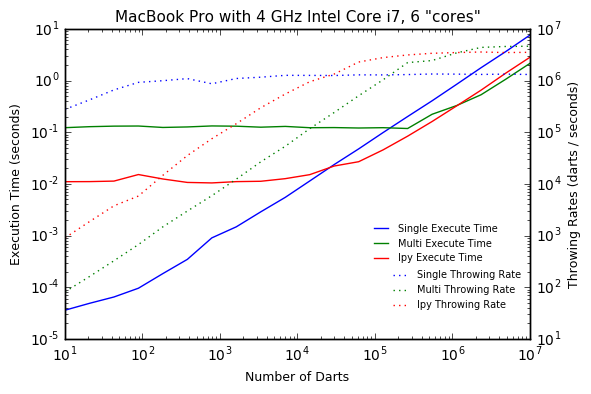

In [42]:
f, ax = plt.subplots()

ax.set_title('MacBook Pro with 4 GHz Intel Core i7, 6 "cores"', fontsize = 11, y = 1.00)
ax.set_xlabel("Number of Darts", fontsize = 9)

npData6 = np.array(parData6)

ax.set_ylabel("Execution Time (seconds)", fontsize = 9)
t1 = ax.loglog(npData6[:, 0], npData6[:, 1], label = 'Single Execute Time')
t2 = ax.loglog(npData6[:, 0], npData6[:, 3], label = 'Multi Execute Time')
t3 = ax.loglog(npData6[:, 0], npData6[:, 5], label = 'Ipy Execute Time')
ax.legend(prop = {'size' : 7}, frameon = False, bbox_to_anchor = (0.95, 0.4))

## Second axis 
ax1 = ax.twinx()
ax1.set_ylabel("Throwing Rates (darts / seconds)", fontsize = 9)
r1 = ax1.loglog(npData6[:, 0], npData6[:, 2], label = 'Single Throwing Rate', ls = ':')
r2 = ax1.loglog(npData6[:, 0], npData6[:, 4], label = 'Multi Throwing Rate', ls = ':')
r3 = ax1.loglog(npData6[:, 0], npData6[:, 6], label = 'Ipy Throwing Rate', ls = ':')
ax1.legend(prop = {'size' : 7}, frameon = False, bbox_to_anchor = (1.0, 0.25))


### Up to 8 Cores

The Macbook Pro I am using has a quad-core processor with two virtual cores each for a total of 8 cores. I compare the above 4 core runs with 8 cores to look at *ipcluster's* ability to handle parallel tasks.   

In [38]:
parData = []

for i in np.logspace(1, 7, 20):
    sRetrn = runParallel(i, 8, 'single', doPrint = False)
    mRetrn = runParallel(i, 8, 'multi', doPrint = False)
    ipyRetrn = runParallel(i, 8, 'ipy', doPrint = False)
    parData.append([i, sRetrn[0], sRetrn[1], mRetrn[0], mRetrn[1], ipyRetrn[0], ipyRetrn[1]])

## Show data 
#parData

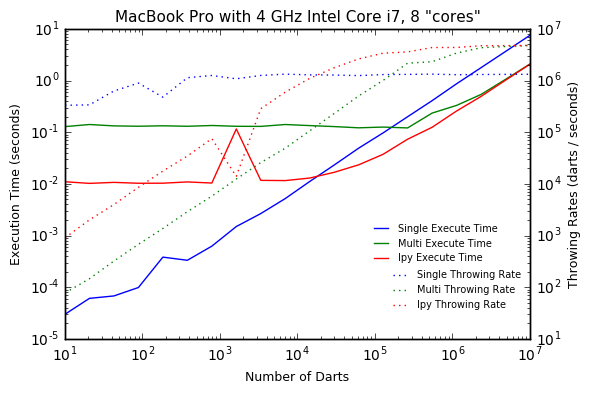

In [40]:
f, ax = plt.subplots()

ax.set_title('MacBook Pro with 4 GHz Intel Core i7, 8 "cores"', fontsize = 11, y = 1.00)
ax.set_xlabel("Number of Darts", fontsize = 9)

npData = np.array(parData)

ax.set_ylabel("Execution Time (seconds)", fontsize = 9)
t1 = ax.loglog(npData[:, 0], npData[:, 1], label = 'Single Execute Time')
t2 = ax.loglog(npData[:, 0], npData[:, 3], label = 'Multi Execute Time')
t3 = ax.loglog(npData[:, 0], npData[:, 5], label = 'Ipy Execute Time')
ax.legend(prop = {'size' : 7}, frameon = False, bbox_to_anchor = (0.95, 0.4))

## Second axis 
ax1 = ax.twinx()
ax1.set_ylabel("Throwing Rates (darts / seconds)", fontsize = 9)
r1 = ax1.loglog(npData[:, 0], npData[:, 2], label = 'Single Throwing Rate', ls = ':')
r2 = ax1.loglog(npData[:, 0], npData[:, 4], label = 'Multi Throwing Rate', ls = ':')
r3 = ax1.loglog(npData[:, 0], npData[:, 6], label = 'Ipy Throwing Rate', ls = ':')
ax1.legend(prop = {'size' : 7}, frameon = False, bbox_to_anchor = (1.0, 0.25))


### Results: 

We can see a clear difference when using *6 versus 8 cores* in execution time and rate. With *8 cores* it took around two seconds for *10^7* darts. We can also see that I started downloading something on my machine while the runs were happening, causing a spike in execution time and relative drop in rate during the *Ipyparallel* runs. 

In general, we see that the overhead for running parallel becomes insignificant when we have large tasks, such as *10^7* number of darts. We can compare these runs to a huge run using a billion darts (below) to see how significant the speedup is with parallel execution (using *Ipyparallel*).

### Huge Run:

Now I try a huge run using all *8 cores* with *10^9* darts - i.e. a billion darts. 

In [ ]:
hugeData = []

for i in np.logspace(1, 9, 20):
    sRetrn = runParallel(i, 8, 'single', doPrint = False)
    mRetrn = runParallel(i, 8, 'multi', doPrint = False)
    ipyRetrn = runParallel(i, 8, 'ipy', doPrint = False)
    hugeData.append([i, sRetrn[0], sRetrn[1], mRetrn[0], mRetrn[1], ipyRetrn[0], ipyRetrn[1]])

## Show data 
#hugeData

f, ax = plt.subplots()

ax.set_title('MacBook Pro with 4 GHz Intel Core i7, 8 "cores"', fontsize = 11, y = 1.00)
ax.set_xlabel("Number of Darts", fontsize = 9)

npHuge = np.array(hugeData)

ax.set_ylabel("Execution Time (seconds)", fontsize = 9)
t1 = ax.loglog(npHuge[:, 0], npHuge[:, 1], label = 'Single Execute Time')
t2 = ax.loglog(npHuge[:, 0], npHuge[:, 3], label = 'Multi Execute Time')
t3 = ax.loglog(npHuge[:, 0], npHuge[:, 5], label = 'Ipy Execute Time')
ax.legend(prop = {'size' : 7}, frameon = False, bbox_to_anchor = (0.95, 0.4))

## Second axis 
ax1 = ax.twinx()
ax1.set_ylabel("Throwing Rates (darts / seconds)", fontsize = 9)
r1 = ax1.loglog(npHuge[:, 0], npHuge[:, 2], label = 'Single Throwing Rate', ls = ':')
r2 = ax1.loglog(npHuge[:, 0], npHuge[:, 4], label = 'Multi Throwing Rate', ls = ':')
r3 = ax1.loglog(npHuge[:, 0], npHuge[:, 6], label = 'Ipy Throwing Rate', ls = ':')
ax1.legend(prop = {'size' : 7}, frameon = False, bbox_to_anchor = (1.0, 0.25))